# Geometric Modeling of EHT Data (Julia 1.9.3 버전)

## 환경 설정 

In [1]:
cd("/home/bread/astro/Comrade.jl/examples/GeometricModeling")

In [3]:
pwd()

"/home/bread/astro/Comrade.jl/examples/GeometricModeling"

In [4]:
import Pkg #hide
__DIR = @__DIR__ #hide

"/home/bread/astro/Comrade.jl/examples/GeometricModeling"

In [5]:
pkg_io = open(joinpath(__DIR, "pkg.log"), "w") #hide


IOStream(<file /home/bread/astro/Comrade.jl/examples/GeometricModeling/pkg.log>)

In [6]:
Pkg.activate(__DIR; io=pkg_io) #hide


In [7]:
Pkg.develop(; path=joinpath(__DIR, "..", ".."), io=pkg_io) #hide


In [8]:
Pkg.instantiate(; io=pkg_io) #hide


In [9]:
Pkg.precompile(; io=pkg_io) #hide


In [10]:
close(pkg_io) #hide
ENV["GKSwstype"] = "nul" #hide

"nul"

In [ ]:
# using Pkg
# Pkg.activate("/home/bread/astro/Comrade.jl/examples/GeometricModeling")
# Pkg.instantiate()

In [ ]:
# 주의! PyCall과 Pyehtim 충돌로 kernel이 죽는 상황이 발생할 수 있음

# using PyCall

In [ ]:
# PyCall.python

In [ ]:
# ENV["PYTHON"] = "/home/bread/anaconda3/envs/astroenv/bin/python"

In [ ]:
# using Pkg
# Pkg.build("PyCall")

In [ ]:
# 변경된 경로 확인

# PyCall.python

## 데이터 로딩

In [2]:
using Pyehtim

In [11]:
using Comrade

[ Info: Precompiling Comrade [99d987ce-9a1e-4df8-bc0b-1ea019aa547b]
[ Info: Precompiling ComradePyehtimExt [af64b4e3-ae20-5f1c-8348-1696443603f2]


Welcome to eht-imaging! v 1.2.7 



In [12]:
using StableRNGs
rng = StableRNG(42)

StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)

In [13]:
obs = ehtim.obsdata.load_uvfits(joinpath(__DIR, 
        "../Data/SR1_M87_2017_096_lo_hops_netcal_StokesI.uvfits"))

Python: <ehtim.obsdata.Obsdata object at 0x7fbb5e910100>

In [14]:
obs = Pyehtim.scan_average(obs.flag_uvdist(uv_min=0.1e9)).add_fractional_noise(0.02)

[ Info: Before homogenizing we have 25 unique times
[ Info: After homogenizing we have 25 unique times


Python: <ehtim.obsdata.Obsdata object at 0x7fbb5e9300d0>

In [15]:
dlcamp, dcphase = extract_table(obs, 
    LogClosureAmplitudes(;snrcut=3.0), 
    ClosurePhases(;snrcut=3.0))

/home/bread/.julia/environments/v1.9/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/bread/.julia/environments/v1.9/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/bread/.julia/environments/v1.9/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(EHTObservation{Float64,Comrade.EHTLogClosureAmplitudeDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 94
, EHTObservation{Float64,Comrade.EHTClosurePhaseDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 118
)

In [16]:
function model(θ)
    (;radius, width, ma, mp, τ, ξτ, f, σG, τG, ξG, xG, yG) = θ
    α = ma.*cos.(mp .- ξτ)
    β = ma.*sin.(mp .- ξτ)
    ring = f*smoothed(modify(MRing(α, β), Stretch(radius, radius*(1+τ)), Rotate(ξτ)), width)
    g = (1-f)*shifted(rotated(stretched(Gaussian(), σG, σG*(1+τG)), ξG), xG, yG)
    return ring + g
end

model (generic function with 1 method)

In [17]:
lklhd = RadioLikelihood(model, dlcamp, dcphase)

RadioLikelihood
	Number of data products: 2


In [18]:
using Distributions, VLBIImagePriors
prior = NamedDist(
          radius = Uniform(μas2rad(10.0), μas2rad(30.0)),
          width = Uniform(μas2rad(1.0), μas2rad(10.0)),
          ma = (Uniform(0.0, 0.5), Uniform(0.0, 0.5)),
          mp = (Uniform(0, 2π), Uniform(0, 2π)),
          τ = Uniform(0.0, 1.0),
          ξτ= Uniform(0.0, π),
          f = Uniform(0.0, 1.0),
          σG = Uniform(μas2rad(1.0), μas2rad(100.0)),
          τG = Uniform(0.0, 1.0),
          ξG = Uniform(0.0, 1π),
          xG = Uniform(-μas2rad(80.0), μas2rad(80.0)),
          yG = Uniform(-μas2rad(80.0), μas2rad(80.0))
        )

[ Info: Precompiling VLBIImagePriors [b1ba175b-8447-452c-b961-7db2d6f7a029]


(radius = Uniform{Float64}(a=4.84813681109536e-11, b=1.454441043328608e-10), width = Uniform{Float64}(a=4.84813681109536e-12, b=4.84813681109536e-11), ma = VLBIImagePriors.TupleDist{2, Tuple{Uniform{Float64}, Uniform{Float64}}}(dists=(Uniform{Float64}(a=0.0, b=0.5), Uniform{Float64}(a=0.0, b=0.5))), ...)


In [19]:
post = Posterior(lklhd, prior)

Posterior(
RadioLikelihood
	Number of data products: 2

Prior:
(radius = Uniform{Float64}(a=4.84813681109536e-11, b=1.454441043328608e-10), width = Uniform{Float64}(a=4.84813681109536e-12, b=4.84813681109536e-11), ma = VLBIImagePriors.TupleDist{2, Tuple{Uniform{Float64}, Uniform{Float64}}}(dists=(Uniform{Float64}(a=0.0, b=0.5), Uniform{Float64}(a=0.0, b=0.5))), ...)

)

In [20]:
logdensityof(post, (radius = μas2rad(20.0),
                  width = μas2rad(10.0),
                  ma = (0.3, 0.3),
                  mp = (π/2, π),
                  τ = 0.1,
                  ξτ= π/2,
                  f = 0.6,
                  σG = μas2rad(50.0),
                  τG = 0.1,
                  ξG = 0.5,
                  xG = 0.0,
                  yG = 0.0))

-4941.906769257404

## Reconstruction

In [21]:
cpost = ascube(post)

TransformedPosterior(
Posterior(
RadioLikelihood
	Number of data products: 2

Prior:
(radius = Uniform{Float64}(a=4.84813681109536e-11, b=1.454441043328608e-10), width = Uniform{Float64}(a=4.84813681109536e-12, b=4.84813681109536e-11), ma = VLBIImagePriors.TupleDist{2, Tuple{Uniform{Float64}, Uniform{Float64}}}(dists=(Uniform{Float64}(a=0.0, b=0.5), Uniform{Float64}(a=0.0, b=0.5))), ...)

)
Transform: Params to [0,1]^14
)

In [22]:
fpost = asflat(post)

TransformedPosterior(
Posterior(
RadioLikelihood
	Number of data products: 2

Prior:
(radius = Uniform{Float64}(a=4.84813681109536e-11, b=1.454441043328608e-10), width = Uniform{Float64}(a=4.84813681109536e-12, b=4.84813681109536e-11), ma = VLBIImagePriors.TupleDist{2, Tuple{Uniform{Float64}, Uniform{Float64}}}(dists=(Uniform{Float64}(a=0.0, b=0.5), Uniform{Float64}(a=0.0, b=0.5))), ...)

)
Transform: Params to ℝ^14
)

In [23]:
logdensityof(cpost, rand(rng, dimension(cpost)))
logdensityof(fpost, randn(rng, dimension(fpost)))

-16421.89770456522

## Finding the Optimal Image

In [ ]:
# 만약 HTTP 의존성 warning이 발생할 경우 실행  
#
# using Pkg
# Pkg.instantiate()

In [24]:
using ComradeOptimization
using OptimizationBBO

ndim = dimension(fpost)
f = OptimizationFunction(fpost)
prob = Optimization.OptimizationProblem(f, 
                                        randn(rng, ndim), 
                                        nothing, 
                                        lb=fill(-5.0, ndim), 
                                        ub=fill(5.0, ndim))

[ Info: Precompiling ComradeOptimization [26988f03-70df-4135-959e-06268cc6415a]
[ Info: Precompiling SciMLBasePythonCallExt [2797fd30-2078-5027-980c-4c2c8a19c528]
[ Info: Precompiling OptimizationBBO [3e6eede4-6085-4f62-9a71-46d9bc1eb92b]
[ Info: Precompiling BlackBoxOptimRealtimePlotServerExt [63f9f8bc-8213-5f4f-afc1-c0f12bbf518b]


OptimizationProblem. In-place: true
u0: 14-element Vector{Float64}:
 -2.042002086038424
 -0.7870208631180695
  0.5905224676986801
  0.6421092391624518
  0.45523702486217854
  0.05420311090968867
  0.2884763107619252
  0.5868282026416113
 -1.6942586185480404
 -0.6959809938112977
 -0.30096086778202435
  2.1005530576443556
 -0.6896446526429071
 -0.7299727780343646

In [25]:
sol = solve(prob, BBO_adaptive_de_rand_1_bin_radiuslimited(); maxiters=50_000);

In [26]:
xopt = transform(fpost, sol)

(radius = 9.949738821122867e-11, width = 2.0512321033383973e-11, ma = (0.29077487272862906, 0.09464090480688311), mp = (2.4712112459907782, 3.2769613122260393), τ = 0.07604106445585274, ξτ = 0.7538539429920801, f = 0.19056973953206902, σG = 2.3042668397239396e-10, τG = 0.7904601215162416, ξG = 1.048618777833186, xG = -1.9171741247356433e-10, yG = -8.994989247805332e-11)

[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
[ Info: Precompiling DimensionalDataMakie [71847b91-7361-5cb1-9c72-7bdc55e4d1c2]
[ Info: Precompiling VLBISkyModelsMakieExt [1f4dc293-ac58-5c7f-bfaf-a71eff22b721]
[ Info: Precompiling ComradeMakieExt [e85aa35d-4f38-5647-884e-35f553317b57]


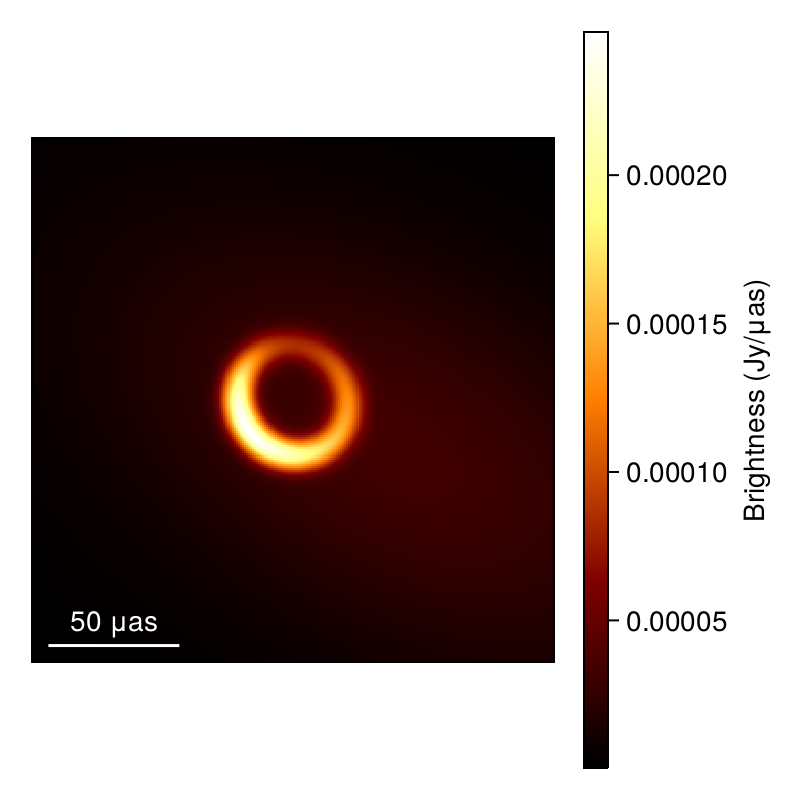

In [27]:
using DisplayAs
import CairoMakie as CM
g = imagepixels(μas2rad(200.0), μas2rad(200.0), 256, 256)
fig = imageviz(intensitymap(model(xopt), g), colormap=:afmhot, size=(400, 400))
DisplayAs.Text(DisplayAs.PNG(fig))

## Quantifying the Uncertainty of the Reconstruction

In [28]:
# While finding the optimal image is often helpful, in science, the most important thing is to
# quantify the certainty of our inferences. This is the goal of Comrade. In the language
# of Bayesian statistics, we want to find a representation of the posterior of possible image
# reconstructions given our choice of model and the data.
#
# Comrade provides several sampling and other posterior approximation tools. To see the
# list, please see the Libraries section of the docs. For this example, we will be using
# [Pigeons.jl](https://github.com/Julia-Tempering/Pigeons.jl) which is a state-of-the-art
# parallel tempering sampler that enables global exploration of the posterior. For smaller dimension
# problems (< 100) we recommend using this sampler especially if you have access to > 1 core.

using Pigeons
pt = pigeons(target = cpost, 
            explorer = SliceSampler(), 
            record = [traces, round_trip, log_sum_ratio], 
            n_chains = 10, 
            n_rounds = 7,
            multithreaded = false)


[ Info: Precompiling Pigeons [0eb8d820-af6a-4919-95ae-11206f830c31]
[ Info: Precompiling BangBangDataFramesExt [d787bcad-b5c5-56bb-adaa-6bfddb178a59]
[ Info: Precompiling TransducersDataFramesExt [cefb4096-3352-5e5f-8501-71f024082a88]
[ Info: Precompiling TransducersOnlineStatsBaseExt [6f45943c-d98e-5e8a-8912-adbe5bfabdb6]
[ Info: Precompiling ComradePigeonsExt [ce13099f-d5f1-5de5-af80-7818dff7a4d7]


───────────────────────────────────────────────────────────────────────────────────────
  scans     restarts      Λ      log(Z₁/Z₀)   min(α)     mean(α)    min(αₑ)   mean(αₑ) 
────────── ────────── ────────── ────────── ────────── ────────── ────────── ──────────
        2          0       4.99   -2.1e+03          0      0.445          1          1 
        4          0        3.5       -622  1.61e-174      0.611          1          1 
        8          0       5.57      -63.3   3.68e-20      0.381          1          1 
       16          0       6.76       50.1    1.3e-14      0.249          1          1 
       32          0       6.99       78.4    0.00576      0.223          1          1 
       64          0       7.07       80.8    0.00194      0.215          1          1 
      128          0       6.91         84   0.000419      0.232          1          1 
───────────────────────────────────────────────────────────────────────────────────────


PT(checkpoint = false, ...)

In [29]:
chain = sample_array(cpost, pt);

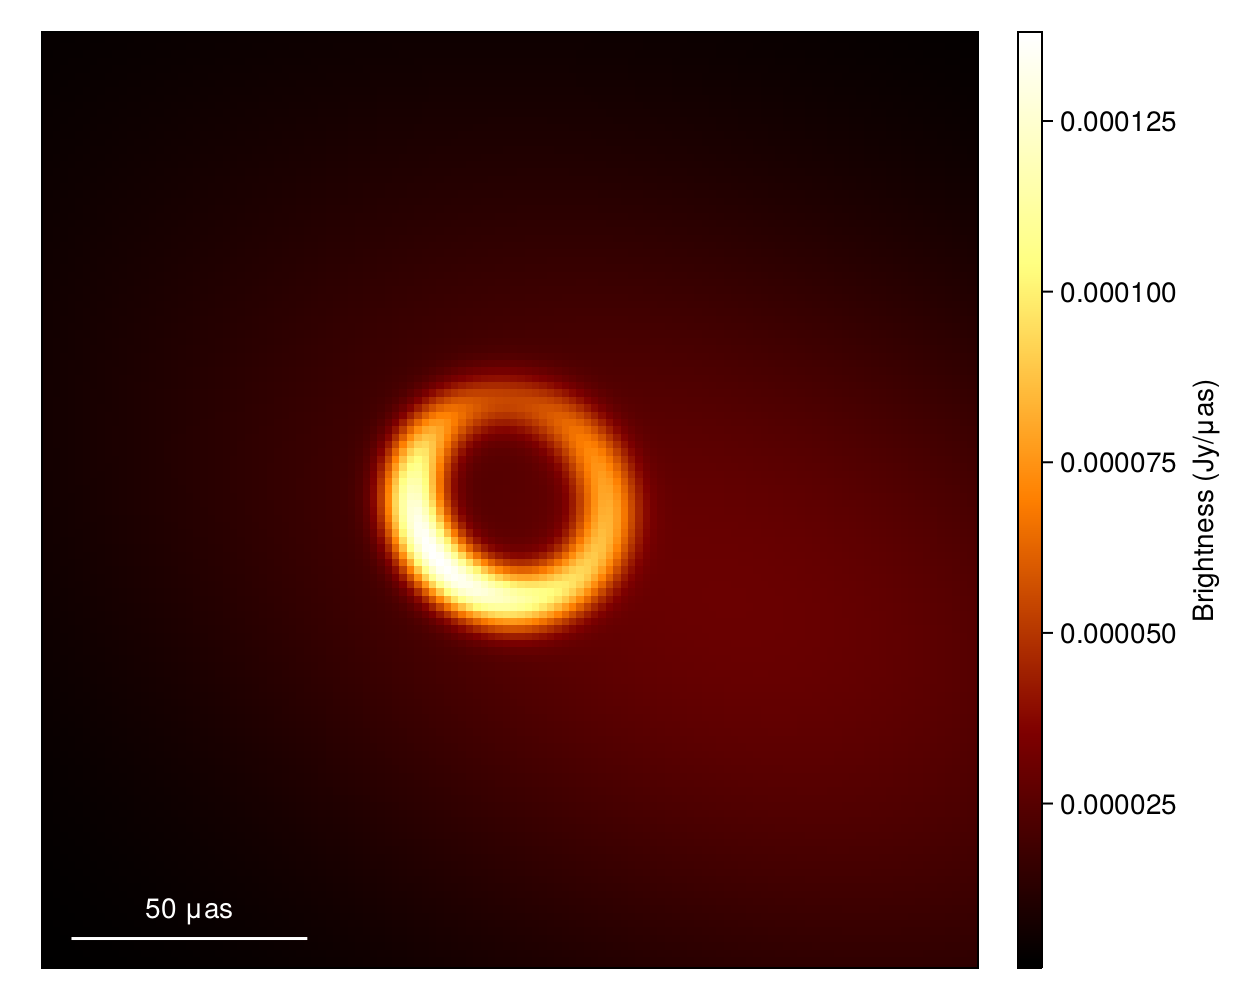

In [30]:
imgs = intensitymap.(skymodel.(Ref(post), 
                    sample(chain, 100)), 
                    μas2rad(200.0), 
                    μas2rad(200.0), 
                    128, 
                    128)
fig = imageviz(imgs[end], colormap=:afmhot)
DisplayAs.Text(DisplayAs.PNG(fig))

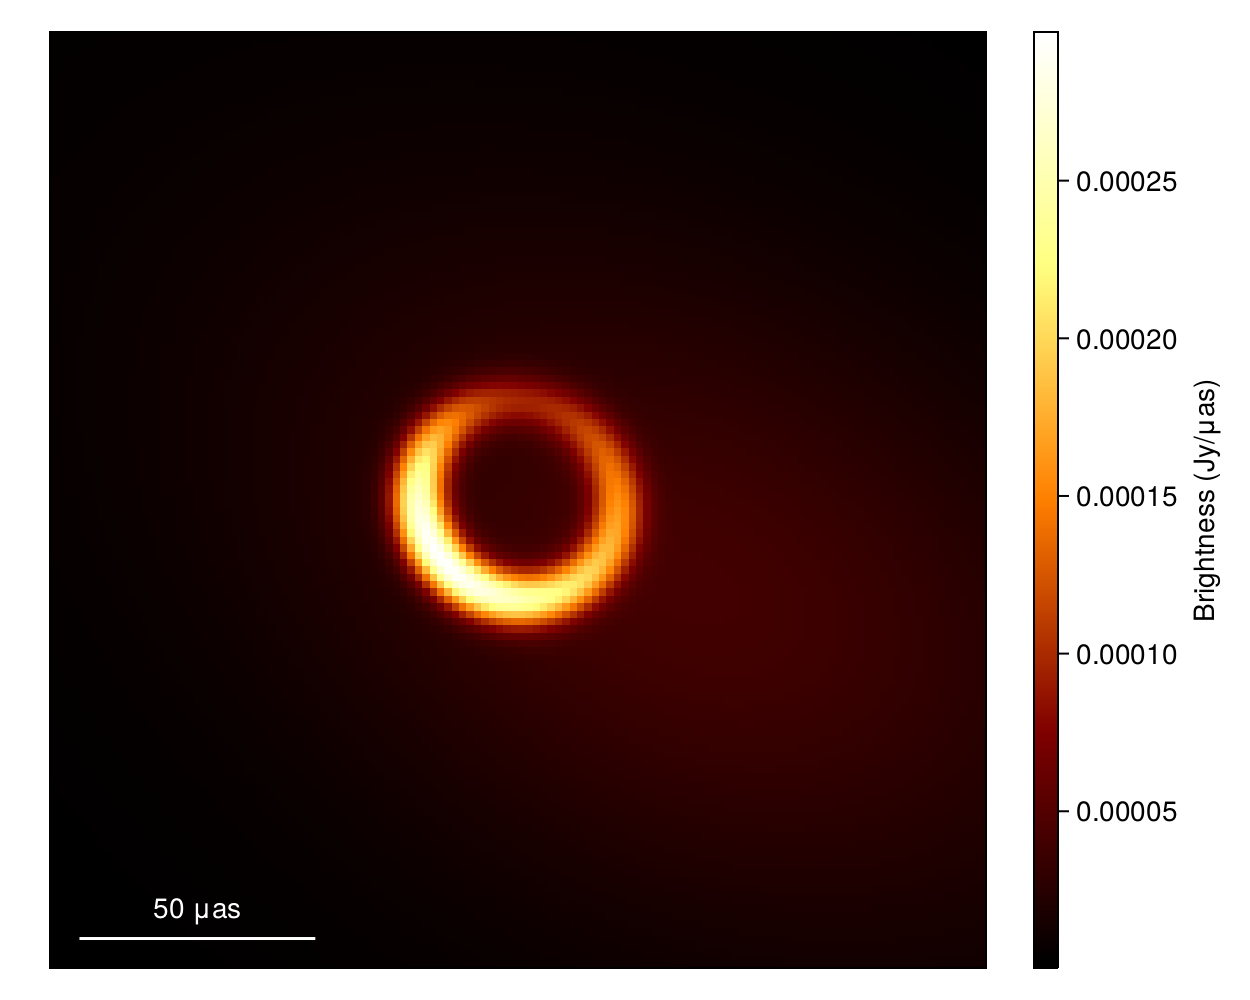

In [31]:
meanimg = mean(imgs)
fig = imageviz(meanimg, colormap=:afmhot)
DisplayAs.Text(DisplayAs.PNG(fig))

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
[ Info: Precompiling GeometryBasicsExt [b238bd29-021f-5edc-8b0e-16b9cda5f63a]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


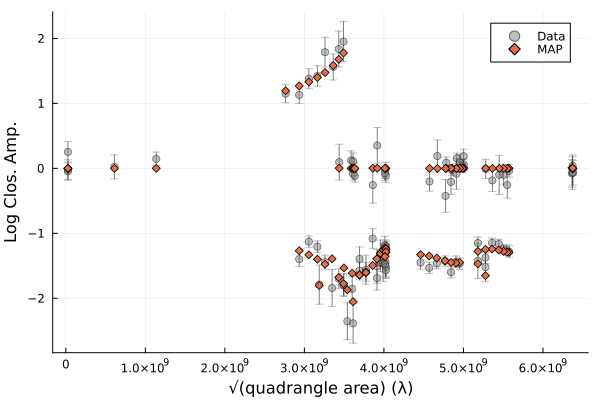

In [32]:
using Plots
p = Plots.plot(model(xopt), dlcamp, label="MAP")
DisplayAs.Text(DisplayAs.PNG(p))

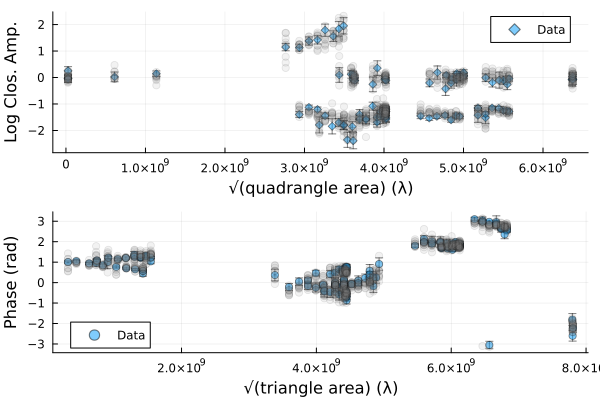

In [33]:
p1 = Plots.plot(dlcamp);
p2 = Plots.plot(dcphase);
uva = [sqrt.(uvarea(dlcamp[i])) for i in 1:length(dlcamp)]
uvp = [sqrt.(uvarea(dcphase[i])) for i in 1:length(dcphase)]
for i in 1:10
    mobs = simulate_observation(post, sample(chain, 1)[1])
    mlca = mobs[1]
    mcp  = mobs[2]
    Plots.scatter!(p1, uva, mlca[:measurement], color=:grey, label=:none, alpha=0.1)
    Plots.scatter!(p2, uvp, atan.(sin.(mcp[:measurement]), cos.(mcp[:measurement])), color=:grey, label=:none, alpha=0.1)
end
p = plot(p1, p2, layout=(2,1))
DisplayAs.Text(DisplayAs.PNG(p))

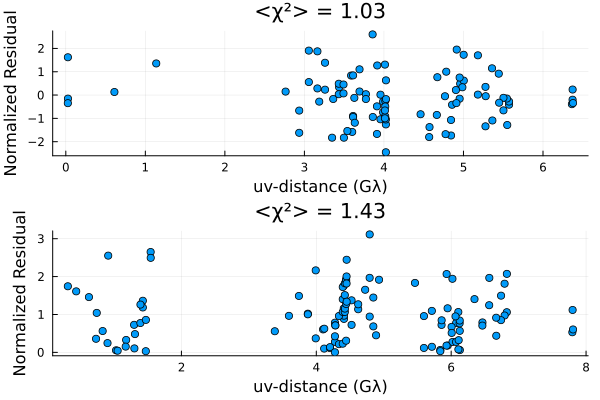

In [34]:
p1 = residual(model(chain[end]), dlcamp)
p2 = residual(model(chain[end]), dcphase)
p = plot(p1, p2, layout=(2,1))
DisplayAs.Text(DisplayAs.PNG(p))